# 

# 

<img src="images/Elastic.png" style="height: 80px"/>

# Security Solution
### Rule-based signals generation
###### Domenico Andreoli
###### Security Engineering Productivity

## Hacking page

In [1]:
%%javascript
$("#notebook").attr("data-background-transition", "none")
$(".backgrounds").css("display", "block")

<IPython.core.display.Javascript object>

In [2]:
from presentation import *

## Where does it come from?

&#129514; Test: rules had to work also with documents on a remote cluster (CCS)

&#9989; Plenty of rules available

&#9989; Detection engine

&#10060; What documents?


* generate from beats
* copy from cluster
* reuse from other tests
* write manually

## There must be a way...

* A rule is a wrapper around a query
* A query already _tells_ what it wants

\
&#128073; `process where process.name == "cmd.exe"`

just wants a document with field `process.name` containing `cmd.exe`

\
Can't we automate this process? Yes!*

<small>\* sometimes</small>

In [3]:
import eql
from IPython.display import display
from detection_rules.events_emitter import emitter
from detection_rules.ast_dag import draw_ast

def parse(query, draw=False):
    try:
        with eql.parser.elasticsearch_syntax:
            ast = eql.parse_query(query)
        if draw:
            display(draw_ast(ast), ast)
        else:
            return ast
    except Exception as e:
        print(e)

def emit(query, timestamp=False, draw=False):
    try:
        ast = parse(query)
        branches = emitter.branches_from_ast(ast)
        docs = emitter.docs_from_branches(branches, timestamp)
        if draw:
            display(draw_ast(ast), docs)
        else:
            return docs
    except Exception as e:
        print(e)


In [4]:
def draw(query):
    try:
        with eql.parser.elasticsearch_syntax:
            ast = eql.parse_query(query)
        return draw_ast(ast)
    except Exception as e:
        print(e)

## EQL examples

In [5]:
emit('''
    process where process.name : ("*.EXE", "*.DLL", "*.BAT")
''')

[[{'process': {'name': 'myodbkjv.bat'}, 'event': {'category': ['process']}}]]

In [6]:
emit('''
    network where cidrMatch(destination.ip, "10.0.0.0/8", "192.168.0.0/24")
''')

[[{'destination': {'ip': '10.230.114.33'},
   'event': {'category': ['network']}}]]

In [7]:
emit('''
    sequence by user.id
      [process where process.name : ("*.exe")] by process.name
      [process where process.name : "regedit.exe"] by process.parent.name
''')

[[{'process': {'name': 'mpf.exe'},
   'event': {'category': ['process']},
   'user': {'id': 'DEP'}},
  {'process': {'name': 'regedit.exe', 'parent': {'name': 'mpf.exe'}},
   'event': {'category': ['process']},
   'user': {'id': 'DEP'}}]]

## How it works?

These are the high level steps:

1. The query is parsed, an AST is generated
2. The fields constraints are collected from the AST
3. The constraint problems are solved, if possible
4. Field-value pairs are translated to a document

## Query is parsed

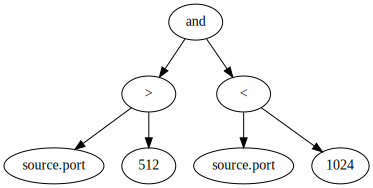

PipedQuery(first=EventQuery(event_type='network', query=And(terms=[Comparison(left=Field(base='source', path=['port']), comparator='>', right=Number(value=512)), Comparison(left=Field(base='source', path=['port']), comparator='<', right=Number(value=1024))])), pipes=[])

In [8]:
parse('''
    network where source.port > 512 and source.port < 1024
''', draw=True)

## Constraints are collected

In [9]:
ast = parse('''
    network where source.port > 512 and source.port < 1024
''')
emitter.branches_from_ast(ast)

[[<detection_rules.constraints.Constraints at 0x10ef52f10>]]

In [10]:
ast = parse('''
    network where source.port > 512 or source.port < 1024
''')
emitter.branches_from_ast(ast)

[[<detection_rules.constraints.Constraints at 0x10ef52d60>],

In [11]:
ast = parse('''
    sequence by user.id
      [process where process.name : ("*.exe")] by process.name
      [process where process.name : "regedit.exe"] by process.parent.name
''')
emitter.branches_from_ast(ast)

[[<detection_rules.constraints.Constraints at 0x10ef5d790>,

## Constraints problems are solved

In [12]:
ast = parse('''
    network where source.port > 512 and source.port < 1024
''')
[list(c.resolve(emitter.schema)) for b in emitter.branches_from_ast(ast) for c in b]

[[('source.port', 955), ('event.category', ['network'])]]

In [13]:
ast = parse('''
    network where source.port > 512 or source.port < 1024
''')
[list(c.resolve(emitter.schema)) for b in emitter.branches_from_ast(ast) for c in b]

[[('source.port', 3744), ('event.category', ['network'])],
 [('source.port', 752), ('event.category', ['network'])]]

In [14]:
ast = parse('''
    sequence by user.id
      [process where process.name : ("*.exe", "*.dll")] by process.name
      [process where process.name : "regedit.exe"] by process.parent.name
''')
[list(c.resolve(emitter.schema)) for b in emitter.branches_from_ast(ast) for c in b]

[[('process.name', 'bmueyvckvzvjust.dll'),
  ('event.category', ['process']),
  ('user.id', 'wYR')],
 [('process.name', 'regedit.exe'),
  ('event.category', ['process']),
  ('process.parent.name', 'bmueyvckvzvjust.dll'),
  ('user.id', 'wYR')]]

## Field-value pairs are translated to a document

In [15]:
ast = parse('''
    sequence by user.id
      [process where process.name : ("*.exe", "*.dll")] by process.name
      [process where process.name : "regedit.exe"] by process.parent.name
''')
[emitter.docs_from_branch(b) for b in emitter.branches_from_ast(ast)]

[[{'process': {'name': 'lznqduch.exe'},
   'event': {'category': ['process']},
   'user': {'id': 'Lgv'},
   '@timestamp': 1644596608653},
  {'process': {'name': 'regedit.exe', 'parent': {'name': 'lznqduch.exe'}},
   'event': {'category': ['process']},
   'user': {'id': 'Lgv'},
   '@timestamp': 1644596608654}]]